In [2]:
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt

# Reading and convering the LSST filter data

r = pd.read_csv('../data/filters/LSST_r.dat', delim_whitespace=True)
#red filter from 5371-7059
g = pd.read_csv('../data/filters//LSST_g.dat', delim_whitespace=True)
# green filter from 3865-5669
i = pd.read_csv('../data/filters//LSST_i.dat', delim_whitespace=True)
# infrared filter from 6761-8329
u = pd.read_csv('../data/filters//LSST_u.dat', delim_whitespace=True)
# ultraviolet filter from 3201-4085
y = pd.read_csv('../data/filters//LSST_y.dat', delim_whitespace=True)
# y filter from 9085-10989
z = pd.read_csv('../data/filters//LSST_z.dat', delim_whitespace=True)
# z filter from 8031-9385
r_eff = r.iloc[:, 1]  # 0 for wavelength 1 for transmission
g_eff = g.iloc[:, 1]
i_eff = i.iloc[:, 1]  
u_eff = u.iloc[:, 1]
y_eff = y.iloc[:, 1]
z_eff = z.iloc[:, 1]


r_filter = r.iloc[:, 0]  # 0 for wavelength 1 for transmission
g_filter = g.iloc[:, 0]
i_filter = i.iloc[:, 0]  
u_filter = u.iloc[:, 0]
y_filter = y.iloc[:, 0]
z_filter = z.iloc[:, 0]

r_wave = r_filter * 1e-10 # I think its in angstroms  
g_wave = g_filter * 1e-10
i_wave = i_filter * 1e-10
u_wave = u_filter * 1e-10
y_wave = y_filter * 1e-10
z_wave = z_filter * 1e-10

# converting wavelength to frequency
c = 3e8 #speed of light
r_freq = c/r_wave #using c already below as 3e8
g_freq = c/g_wave
i_freq = c/i_wave
u_freq = c/u_wave
y_freq = c/y_wave
z_freq = c/z_wave


#planck law for wavelengths
t = 5800 #Temp of sun
h = 6.626e-34 #Plank constant
c = 3e8 #speed of light
k = 1.38e-23 #Boltzmann constant
l_r = r_wave # wavelngth too just easier to use this in formula 
l_g = g_wave
l_i = i_wave
l_u = u_wave
l_y = y_wave
l_z = z_wave

plank_r = (((2*h*(c**2))/(l_r**5)))*((1/(np.exp((h*c)/(l_r*k*t))-1))) #plank law for r just copy this for other filt
plank_g = (((2*h*(c**2))/(l_g**5)))*((1/(np.exp((h*c)/(l_g*k*t))-1)))
plank_i = (((2*h*(c**2))/(l_i**5)))*((1/(np.exp((h*c)/(l_i*k*t))-1)))
plank_u = (((2*h*(c**2))/(l_u**5)))*((1/(np.exp((h*c)/(l_u*k*t))-1)))
plank_y = (((2*h*(c**2))/(l_y**5)))*((1/(np.exp((h*c)/(l_y*k*t))-1)))
plank_z = (((2*h*(c**2))/(l_z**5)))*((1/(np.exp((h*c)/(l_z*k*t))-1)))

# Combining the filter data and plank law 

r_trans = plank_r * r_eff #total output for given filter
g_trans = plank_g * g_eff
i_trans = plank_i * i_eff
u_trans = plank_u * u_eff
y_trans = plank_y * y_eff
z_trans = plank_z * z_eff

r_total = sum(r_trans) #combinging the 1600ish values in each filter for total output
g_total = sum(g_trans)
i_total = sum(i_trans)
u_total = sum(u_trans)
y_total = sum(y_trans)
z_total = sum(z_trans)

#ratio of highest output to other filters
r_ratio = r_total / g_total
g_ratio = g_total / g_total
i_ratio = i_total / g_total
u_ratio = u_total / g_total
y_ratio = y_total / g_total
z_ratio = z_total / g_total

#Planck law graph
total_wave = np.concatenate((r_wave, g_wave, i_wave, u_wave, y_wave, z_wave)) #combining all the wavelengths in one 
plank_total = np.concatenate((plank_r, plank_g, plank_i, plank_u, plank_y, plank_z)) #Full Planck law
trans_total = np.concatenate((r_trans, g_trans, i_trans, u_trans, y_trans, z_trans))
total_freq = np.concatenate((r_freq, g_freq, i_freq, u_freq, y_freq, z_freq))
freq_index = np.argsort(total_freq) #sorting the frequency values

# To make plancks law graph smooth 
total_index = np.argsort(total_wave)
total_wave = total_wave[total_index]
plank_total = (plank_total[total_index])*5e-1 #multiplied to make fit the graph 

# for y axis
wavelength = np.linspace(min(trans_total), max(trans_total), len(total_wave)) 
alpha = 1
flux = (wavelength**(-alpha))
#flux *= flux.max()


print(r_total, g_total, i_total, u_total, y_total, z_total)
print(r_freq)


1.478394677861521e+16 1.4827916403347366e+16 1.0684893071692444e+16 2244757063838288.8 2810554652713769.0 6578972742849477.0
0       5.585552e+14
1       5.584512e+14
2       5.583473e+14
3       5.582434e+14
4       5.581395e+14
            ...     
1684    4.252303e+14
1685    4.251701e+14
1686    4.251098e+14
1687    4.250496e+14
1688    4.249894e+14
Name: 5370, Length: 1689, dtype: float64


/var/folders/pw/nc5rj5md667b29kntncq7jbw0000gn/T/ipykernel_54841/4194303396.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  r = pd.read_csv('../data/filters/LSST_r.dat', delim_whitespace=True)
/var/folders/pw/nc5rj5md667b29kntncq7jbw0000gn/T/ipykernel_54841/4194303396.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  g = pd.read_csv('../data/filters//LSST_g.dat', delim_whitespace=True)
/var/folders/pw/nc5rj5md667b29kntncq7jbw0000gn/T/ipykernel_54841/4194303396.py:12: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  i = pd.read_csv('../data/filters//LSST_i.dat', delim_whitespace=True)
/var/folders/pw/nc5rj5md667b29kntncq7jbw0000gn/T/ipykernel_54841/4194303396.py:14: FutureWarning: The 'delim_wh

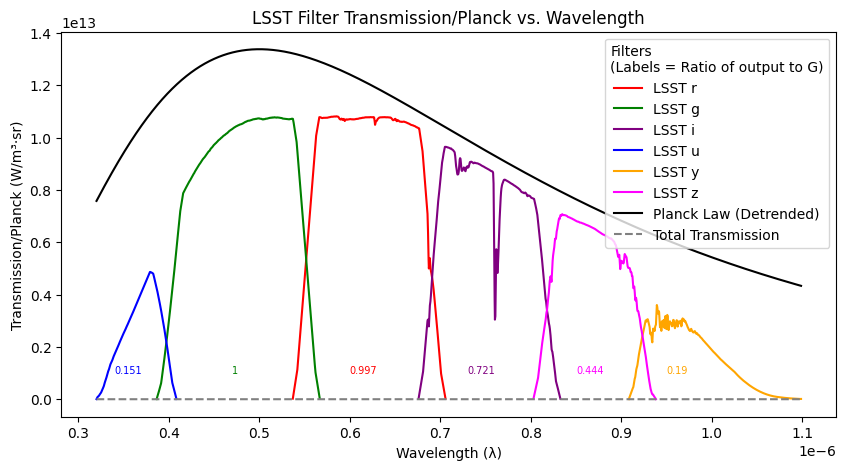

In [3]:
# Plot Code
plt.figure(figsize=(10, 5))
plt.plot(r_wave, r_trans, color='red', label='LSST r')
plt.plot(g_wave, g_trans, color='green', label='LSST g')
plt.plot(i_wave, i_trans, color='purple', label='LSST i')
plt.plot(u_wave, u_trans, color='blue', label='LSST u')
plt.plot(y_wave, y_trans, color='orange', label='LSST y')
plt.plot(z_wave, z_trans, color='magenta', label='LSST z')
plt.plot(total_wave, plank_total, color='black', label='Planck Law (Detrended)')
plt.plot(total_wave, flux, color='gray', linestyle='--', label='Total Transmission')

# Plot Labels 
plt.xlabel("Wavelength (λ)")
plt.ylabel("Transmission/Planck (W/m³·sr)")
plt.title("LSST Filter Transmission/Planck vs. Wavelength")
plt.annotate(f'{u_ratio:.3g}', (0.34e-6, 0.1e13), fontsize=7, color='blue') #for u filter
plt.annotate(f'{g_ratio:.3g}', (0.47e-6, 0.1e13), fontsize=7, color='green') #for g filter
plt.annotate(f'{r_ratio:.3g}', (0.6e-6, 0.1e13), fontsize=7, color='red') #for r filter
plt.annotate(f'{i_ratio:.3g}', (0.73e-6, 0.1e13), fontsize=7, color='purple') #for i filter
plt.annotate(f'{y_ratio:.3g}', (0.95e-6, 0.1e13), fontsize=7, color='orange') #for y filter
plt.annotate(f'{z_ratio:.3g}', (0.85e-6, 0.1e13), fontsize=7, color='magenta') #for z filter
plt.legend(title="Filters\n(Labels = Ratio of output to G)",loc='upper right')

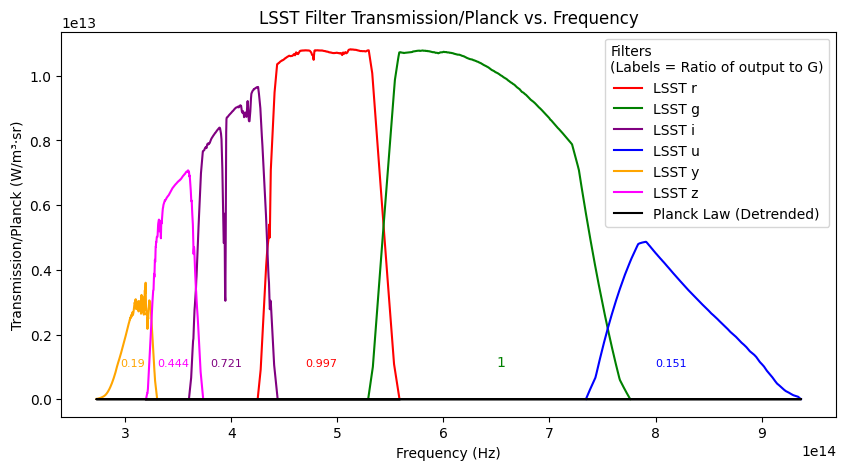

In [49]:
# Plot Code
plt.figure(figsize=(10, 5))
plt.plot(r_freq, r_trans, color='red', label='LSST r')
plt.plot(g_freq, g_trans, color='green', label='LSST g')
plt.plot(i_freq, i_trans, color='purple', label='LSST i')
plt.plot(u_freq, u_trans, color='blue', label='LSST u')
plt.plot(y_freq, y_trans, color='orange', label='LSST y')
plt.plot(z_freq, z_trans, color='magenta', label='LSST z')
plt.plot(total_freq, flux, color='black', label='Planck Law (Detrended)')


#labels
plt.xlabel("Frequency (Hz)")
plt.ylabel("Transmission/Planck (W/m³·sr)")
plt.title("LSST Filter Transmission/Planck vs. Frequency")
plt.annotate(f'{u_ratio:.3g}', (8e14, 0.1e13), fontsize=8, color='blue') #for u filter
plt.annotate(f'{g_ratio:.3g}', (6.5e14, 0.1e13), fontsize=10, color='green') #for g filter
plt.annotate(f'{r_ratio:.3g}', (4.7e14, 0.1e13), fontsize=8, color='red') #for r filter
plt.annotate(f'{i_ratio:.3g}', (3.8e14, 0.1e13), fontsize=8, color='purple') #for i filter
plt.annotate(f'{y_ratio:.3g}', (2.95e14, 0.1e13), fontsize=8, color='orange') #for y filter
plt.annotate(f'{z_ratio:.3g}', (3.3e14, 0.1e13), fontsize=8, color='magenta') #for z filter
plt.legend(title="Filters\n(Labels = Ratio of output to G)",loc='upper right')